## Временные ряды. ARIMA

Содержание:
* [Time Series "Потребление энергии"](#ts)
* [Подбор параметров и обучение SARIMAX](#srchm)
* [Сравнение моделей SARIMA для месячных (data_m) и недельных (data_w) семплов](#srchw)

## Time Series "Потребление энергии"
<left><a class="anchor" id="ts"></a><left>
Временной ряд связан с измерением потребления энергии в отдельных регионах США в период 2002 по 2018 г. (PJM Hourly Energy Consumption Data
https://www.kaggle.com/robikscube/hourly-energy-consumption ). Содержит часовые измерения и после обработки добавлены метки по времени для календаря.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.metrics import mean_squared_error
import os
import warnings
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
from random import random
import itertools

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#Path_Energy = 'PJME_hourly.csv'
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])

In [3]:
# Ресемплинг данных

data_d = data.copy().resample('D').mean()
data_m = data.resample('M').mean()
data_w = data.resample('W').mean()
data_Y = data.resample('3M').mean()

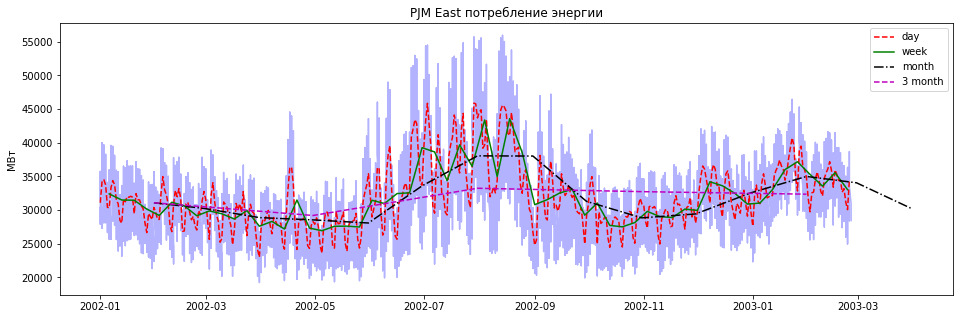

In [4]:
# Визуализация полученных семплов

plt.figure(figsize =(16,5))
plt.plot( data.index[:5*24*7*4*3], data['PJME_MW'].values[:5*24*7*4*3], 'b',alpha =0.3 )
plt.plot( data_d.index[:5*7*4*3], data_d['PJME_MW'].values[:5*7*4*3], '--r',label='day' )
plt.plot( data_w.index[:5*4*3], data_w['PJME_MW'].values[:5*4*3], 'g',label='week'  )
plt.plot( data_m.index[:5*3], data_m['PJME_MW'].values[:5*3], '-.k',label='month'  )
plt.plot( data_Y.index[:5], data_Y['PJME_MW'].values[:5], '--m',label='3 month'  )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.legend()
plt.show()

In [5]:
# Функция для профилирования необходимых статистик

def tsplot(y, lags=None, figsize=(12, 7), style='seaborn-white'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y, regression='ctt')[1])

        plt.tight_layout()
    return

## Подбор параметров и обучение SARIMAX на месячных данных
<left><a class="anchor" id="srchm"></a><left>

Критерий Дики-Фуллера: p=0.524786


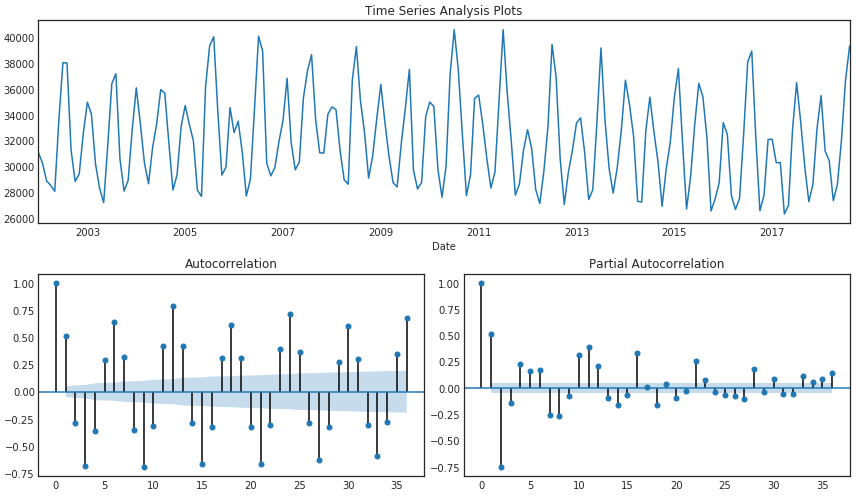

In [12]:
tsplot(data_m['PJME_MW'], lags=36)

Autocorrelation (ACF) - автокорреляционная функция, по коррелограмме которой можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA

Partial Autocorrelation (PACF) - автокорреляционная функция первых разностей, по коррелограмме которой можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR

- На тесте ACF показаывает наличие цикла (3, 6, 9, 12, ... месяцы) - это годовые сезонные изменения по всему периоду наблюдений. Для разностей важными являются значения внутри первых 3-х значений (PACF). Целесообразно принять параметр кратный 3-х месячному циклу.

- Критерий Дики-Фуллера (p=0.52) показал, что ряд не стационарен на данном временном лаге (не отверг нулевую гипотезу о наличии единичного корня)

In [8]:
# Задаем определенный параметр сезонности
seasonal_period = 6

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 0, 2, 6)
SARIMAX: (0, 0, 2) x (0, 1, 0, 6)
SARIMAX: (0, 0, 2) x (0, 1, 1, 6)


In [9]:
# В качестве метрики качества модели используется информационный критерий Акаике (AIC)

params_ = []

# размер выборки для анализа
analysis_set = 30

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-analysis_set],order=param,
                                    seasonal_order=param_seasonal ,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

            results = mod.fit()
            # print('ARIMA{}x{}3 - AIC:{}'.format(param, param_seasonal, results.aic))
            params_.append((results.aic, param, param_seasonal)) 
        except:
            continue

In [10]:
len(params_)

729

In [11]:
# Функция поиска лучших параметров

def get_best_params(params_list, cols_list):
    
    df_ = pd.DataFrame(data=params_list, columns = cols_list)
    best_param = df_.loc[df_['aic'] == df_['aic'].min()].values.tolist()
    
    print(f'Best params: min AIC: {best_param[0][0]}, pdq: {best_param[0][1]}, pdqs: {best_param[0][2]}')
    return best_param[0]

cols_list = ['aic', 'param', 'param_seasonal']
best_param = get_best_params(params_, cols_list)

Best params: min AIC: 2560.618324091308, pdq: (1, 1, 2), pdqs: (0, 2, 2, 6)


Результаты работы модели по подобранным параметрам:

In [12]:
# Вывод статистик SARIMAX

test_fraq = 0.2 # Размер тестовой выборки, %
test_sample = int(len(data_m) * test_fraq)

mod = sm.tsa.statespace.SARIMAX(data_m['PJME_MW'].values[:-test_sample],
                                order=best_param[1],
                                seasonal_order=best_param[2],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_opt = mod.fit()
print(results.summary().tables[0], results.summary().tables[1])

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  170
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 6)   Log Likelihood               -1329.791
Date:                           Thu, 23 Jan 2020   AIC                           2677.581
Time:                                   15:16:31   BIC                           2704.120
Sample:                                        0   HQIC                          2688.366
                                           - 170                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

Анализ результатов по results:

- коэффициенты при элементах модели имеют достаточно большие значения (особенно важны составляющие сглаживания coef: ma.L1, ma.L2 , ma.S.L26)

- Остатки ряда (results.resid) не имеют значительной корреляции. Это говорит о том, что ошибки модели носят случайный характер.

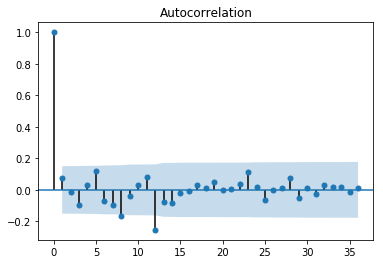

In [13]:
# Оценка автокорелляции ошибки со своими предыдущими значениями

sm.graphics.tsa.plot_acf(results.resid, lags=36)
plt.show()

Визуализация plot_diagnostics: 
- **Standardized residual** - остатки ряда
- **Histogram plus estimated density** - гистограмма для остатков ряда: плотность распределения близка к нормальной
- **Normal Q-Q** - упорядоченное распределение остатков (квантильное). Диаграмма показала достаточно хорошее распределение без значительных отклонений от общей линии тренда
- **Correlogram** - коррелограмма остатков

Результаты диагностики показали, что построенная модель приемлема для прогнозирования.

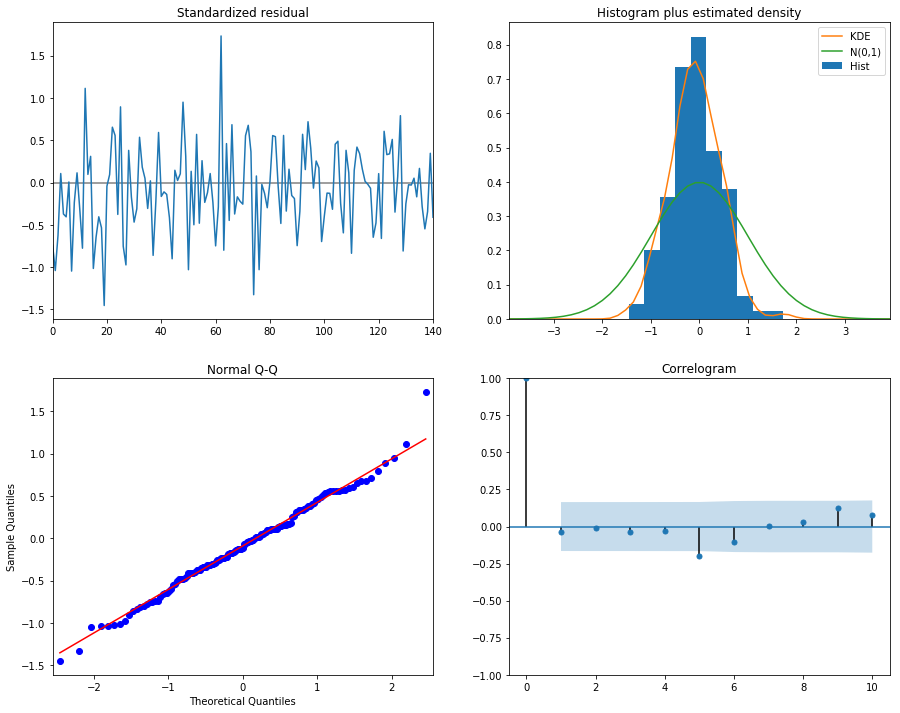

In [14]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [15]:
adf_test = sm.tsa.stattools.adfuller(results_opt.resid)
print(adf_test)

(-7.289076928671188, 1.432979758921743e-10, 14, 145, {'1%': -3.476273058920005, '5%': -2.881687616548444, '10%': -2.5775132580261593}, 2638.374164596863)


ADF тест (adf_test[1] = 0) показывает, что пока остатки являются стационарным рядом,и хотя модель может быть оптимизирована, она адекватно описывает поведение ряда во времени, можно уверенно прогнозировать значения модели в диапазоне дисперсии остатков.

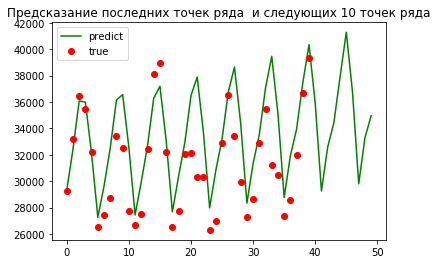

In [16]:
# Отрисовка графика и визуализация прогноза на 10 шагов вперед

steps_forward = 10 # 10 значений вперед
pred_dynamic_opt = results_opt.forecast(test_sample + steps_forward) 

plt.plot(pred_dynamic_opt,'g', label='predict' )

plt.plot(data_m['PJME_MW'].values[-test_sample:],'or',label='true') # test_sample = 40
plt.title('Предсказание последних точек ряда  и следующих 10 точек ряда')
plt.legend()

plt.show()

In [17]:
y_true = data_m['PJME_MW'].values[-test_sample:]
y_pred = pred_dynamic_opt[:-steps_forward]

In [18]:
# Метрика качества (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

er_g = mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
print(f'Средняя ошибка модели: {round(er_g, 2)} %')

Средняя ошибка модели: 7.49 %


In [19]:
results_opt.save('rez_model.h5') # t_rez = sm.load('rez_model.h5')

## Сравнение моделей SARIMA для месячных (data_m) и недельных (data_w) семплов
<left><a class="anchor" id="srchw"></a><left>

### Построение модели и вывод статистик для недельных семплов

- в отличие от data_m (месячный ряд), data_w (недельный) имеет стационарный вид на заданном промежутке (Критерий Дики-Фуллера: p=0.0)

- в пиковых значениях корреляции временной лаг аналогичен для обоих рядов, сохраняется корреляция для квартальных лагов. Наиболее выражен годовой лаг.

Критерий Дики-Фуллера: p=0.000000


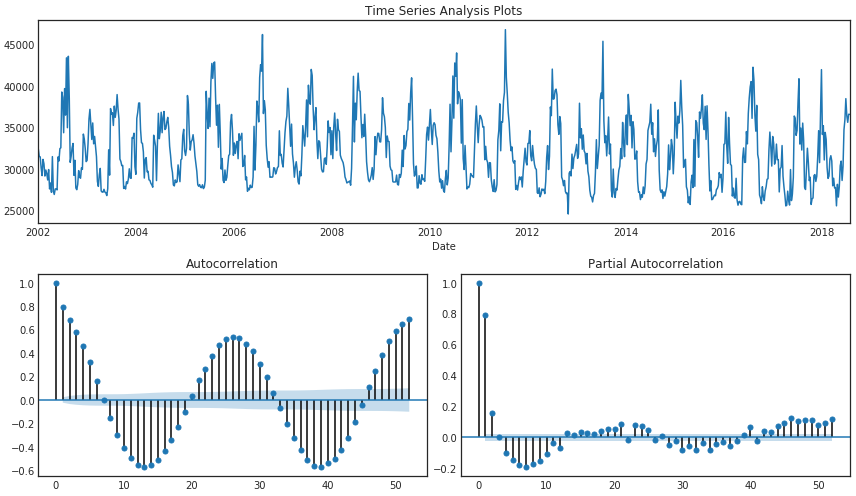

In [20]:
tsplot(data_w['PJME_MW'], lags=52)

In [21]:
# Задаем определенный параметр сезонности
seasonal_period = 26 # сезонность 26 недель (6 мес)

# Определим p, d и q в диапазоне 0-3
p = d = q = range(0, 3)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
# зададим сезонность p, q и q
seasonal_pdq = [(x[0], x[1], x[2], seasonal_period) for x in list(itertools.product(p, d, q))]

В результате подбора лучшие результаты на недельных данных параметры модели SARIMA(0,0, 1)x(1, 1, 2, 26) - AIC:14254.93 (для p,q,d,ps,ds,qs из диапазона [0,1,2]).

- data_m AIC: 2560.6 (data_w AIC: 14254.9 ). Соответственно т.е. месячные имеют более высокое качество и пригодность для построения модели

Для сравнения моделей использован размер тестовой выборки 20% (40 значений и 173 значения)

In [22]:
test_fraq = 0.2 # Размер тестовой выборки, %
test_sample = int(len(data_w) * test_fraq) # test_sample = 173  (тестовый набор)

mod = sm.tsa.statespace.SARIMAX(data_w['PJME_MW'].values[:-test_sample],order=[0,0,1],
                                seasonal_order=[1,1,2,26] ,
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_opt_w = mod.fit()
print('AIC:{}',results_opt_w.aic)

AIC:{} 11269.061453770539


In [23]:
print(results_opt_w.summary().tables[0],results_opt_w.summary().tables[1])

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  693
Model:             SARIMAX(0, 0, 1)x(1, 1, 2, 26)   Log Likelihood               -5629.531
Date:                            Thu, 23 Jan 2020   AIC                          11269.061
Time:                                    15:17:08   BIC                          11291.153
Sample:                                         0   HQIC                         11277.653
                                            - 693                                         
Covariance Type:                              opg                                         
========================================================================================== ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------

- Автокорреляция ошибки на остаточных данных (results_opt.resid) для data_m данных незначительна. Для data_w график показывает наличие взаимосвязанной ошибки, что указывает на рост погрешности модели data_w по сравнению с data_m

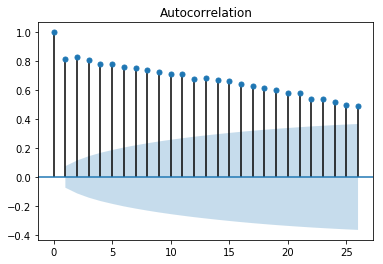

In [24]:
sm.graphics.tsa.plot_acf(results_opt_w.resid, lags=26)
plt.show()

- Гистограмма распределения показывает, что данные data_w более близки к нормальному распределению
- Коррелограмма указывает на наличие шума

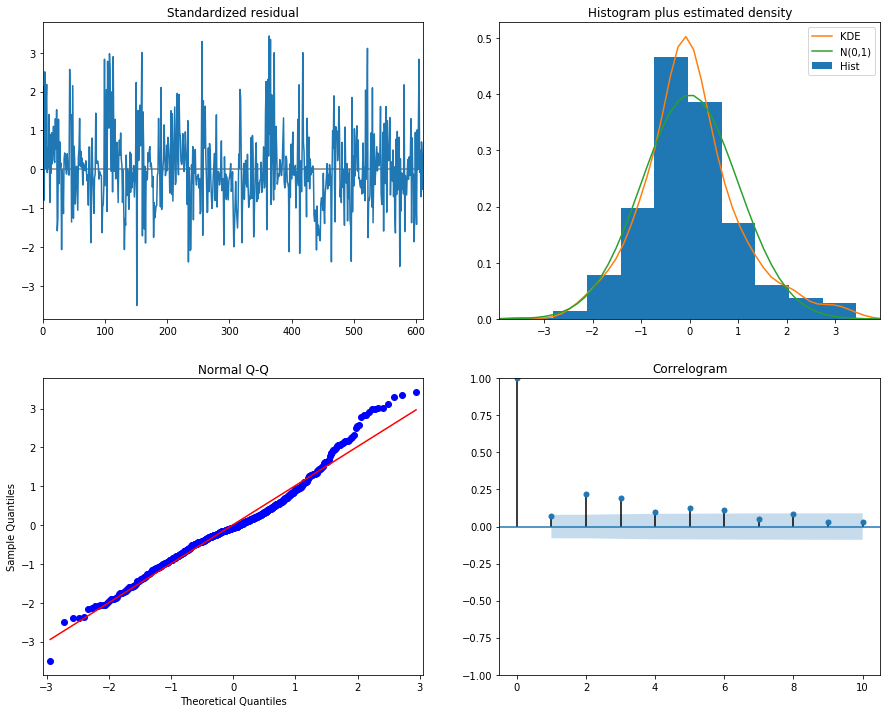

In [25]:
results_opt_w.plot_diagnostics(figsize=(15, 12))
plt.show()

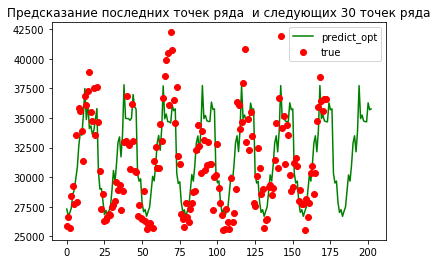

In [26]:
steps_forward = 30 # 30 значений вперед
pred_dynamic_opt = results_opt_w.forecast(test_sample + steps_forward) 

# plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data_w['PJME_MW'].values[-test_sample:],'or',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

In [27]:
y_w_true = data_w['PJME_MW'].values[-test_sample:]
y_w_pred = pred_dynamic_opt[:-steps_forward]

In [28]:
er_g_w = mean_absolute_percentage_error(y_true=y_w_true, y_pred=y_w_pred)
print(f'Средняя ошибка модели: {round(er_g_w, 2)} %')

Средняя ошибка модели: 7.14 %


Итоги сравнения: 

- в отличие от data_m (месячный ряд), **data_w** (недельный) имеет **стационарный вид** (Критерий Дики-Фуллера: p=0.0). Целесообразно провести дифференциальные преобразования для data_m 

- в пиковых значениях корреляции **временной лаг аналогичен для обоих рядов**, сохраняется корреляция для квартальных лагов с выраженными годовыми и полугодовыми лагами.

- **data_m AIC: 2560.6 (data_w AIC: 14254.9 )**. При подборе были выбраны минимальные значения для каждой выборки. Т.к. ряды  разные, метрики не сравниваются между собой на предмет улучшения.

- **Автокорреляция ошибки** на остаточных данных (results_opt.resid) для data_m данных **незначительна**. Для data_w график показывает наличие статистической **ошибки**.

- Гистограмма распределения показывает оба ряда имеют близкое к нормальному распределению.

- **Средняя ошибка прогноза** моделей data_m и data_w соответственно: с одинаковым размером тестовых данных 40 меток для data_m и data_w - **(7.49 % и 5.69 %)**; с пропорциональным размером тестовых данных 20% для каждой выборки: 40 меток для data_m 179 метов для data_w - **(7.49 % и 7.14 %)**. В результате обе модели показали **хороший результат** прогнозов (ошибка < 10%).